**Author** : V.Joan Aléonard<br>
**Last update** :  1st April 2021

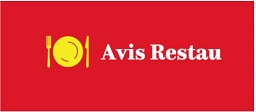

# <font color=red><center>**AVIS RESTAU**</center></font>

**Avis Restau** is a website which connects clients and restaurants:
- The clients can publish reviews and photos of the restaurants;
- The restaurants can leverage from customer's feedbacks for improvement.

**As Data scientist for Avis Restau**, our mission is summarized as follows:

| **Task** | **Objective** | **Available notebook** |
| :-- | :-- | :-- |
| Analyze customers' reviews | **Detect customer's insatisfaction topics** | **<font color=green>Notebook N°1</font>** |
| Treat photo posted by customers | **Classify automatically customer's photos** | Notebook N°2 |
| Collect new data throuhg API | **Enrich our database** | Notebook N°3 |

This notebook is dedicated to 1st task : analyze customer's reviews to detect insatisfaction topics.

# <font color=brown><center>**NOTEBOOK 1 - PRELIMINARY STUDY<br>(TOPIC MODELING)<br>INSATISFACTION TOPICS**</center></font>

# <font color=salmon>PART 1 - DATAFRAME CREATION</font>

In this part, our goal is to gather **reviews from restaurants**, thus:
- we will keep only business within the **restaurant categories** in *businesses data from Yelp*;
- for these restaurants, we will gather around 500k rows of *reviews data from Yelp* that we store in a DataFrame;
- we will keep only the review ID, the stars and the text;
- we will separate the DataFrame in **BAD and GOOD reviews**, respectively with stars under 3 and stars above 3;
- we save the 3 Dataframe for further analysis (if needed).

In [1]:
import numpy as np
import pandas as pd
import json
import pickle

pd.set_option('display.max_colwidth', 200)

In [2]:
# Create DF with business JSON file
business_df = pd.read_json('yelp_academic_dataset_business.json',
                           lines=True)

# Filter on restaurant only to match sector topics
restaurant_df = (
    business_df[business_df.categories.str.contains('Restaurants') == True])

# Create a list of restaurant id
restaurant_list = list(restaurant_df.business_id.unique())

# Create an empty list to store the results
reviews = []

# Loading with pd.read_json raise an error
# Try of other methods
with open('yelp_academic_dataset_review.json') as file:
    for icount, line in enumerate(file):
        # Load JSON by removing white spaces at end of string
        watchlist = json.loads(line.rstrip())
        # Lookup existing business id
        if watchlist['business_id'] in restaurant_list:
            reviews.append(watchlist)
        # Stop at 1m rows
        if icount+1 >= 500000:
            break

# Save as DataFrame
review_df = pd.DataFrame(reviews)
review_df = review_df[['review_id', 'stars', 'text']]

# Drop duplicates
review_df = review_df.drop_duplicates(subset=['text'])

# Filter global DF on stars
bad_rev_df = review_df[review_df.stars < 3]
good_rev_df = review_df[review_df.stars > 3]

# Print shape and display 5 first rows
print('DF reviews shape: ', review_df.shape)
print('Bad reviews shape: ', bad_rev_df.shape)
print('Good reviews shape: ', good_rev_df.shape)
review_df.head()

DF reviews shape:  (330114, 3)
Bad reviews shape:  (67879, 3)
Good reviews shape:  (219433, 3)


,review_id,stars,text
0,LG2ZaYiOgpr2DK_90pYjNw,5.0,"I love Deagan's. I do. I really do. The atmosphere is cozy and festive. The shrimp tacos and house fries are my standbys. The fries are sometimes good and sometimes great, and the spicy dipping sa..."
1,i6g_oA9Yf9Y31qt0wibXpw,1.0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" glop;\n\nMumbly, unengaged waiter;\n\nClueless manager, who seeing us with barely nibbled entrees\non plates shoved forward for pickup, thanked us\nper..."
2,6TdNDKywdbjoTkizeMce8A,4.0,"Oh happy day, finally have a Canes near my casa. Yes just as others are griping about the Drive thru is packed just like most of the other canes in the area but I like to go sit down to enjoy my c..."
3,L2O_INwlrRuoX05KSjc4eg,5.0,"This is definitely my favorite fast food sub shop. Ingredients are everything, and everything I see and taste here tells me that they're using top-grade fresh ingredients. The brisket sandwich is ..."
4,ZayJ1zWyWgY9S_TRLT_y9Q,5.0,"Really good place with simple decor, amazing food and great hospitality.\nVery impressed with the lunch portion. Although service took little extra time but I have no complaints since they are qui..."


In [3]:
# Save to CSV file
review_df.to_csv('review_df.csv',index=False)
good_rev_df.to_csv('good_rev_df.csv',index=False)
bad_rev_df.to_csv('bad_rev_df.csv',index=False)

# <font color=salmon>PART 2 - PRE-PROCESSING</font>

The goal of this part is to **identify which topic is discussed in the bad reviews**.

We call this **<font color=red>Topic modeling</font>** because it is a technique to extract the hidden topics from large volumes of text.

For this purpose, we will use **multiple free open-source Python libraries**, for tokenization, stemming/lemmatization, tagging, classification, etc.:
- [**Gensim**](https://radimrehurek.com/gensim/index.html);
- [**NLTK**](https://www.nltk.org/);
- [**Spacy**](https://spacy.io/).

In [4]:
# Re-import librairies
import numpy as np
import pandas as pd
import json
import pickle

pd.set_option('display.max_colwidth', 200)

# (Re)Load the bad reviews dataframe
bad_rev_df = pd.read_csv('bad_rev_df.csv')

# Display shape and 5 first rows
print(bad_rev_df.shape)
bad_rev_df.head()

(67879, 3)


,review_id,stars,text
0,i6g_oA9Yf9Y31qt0wibXpw,1.0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" glop;\n\nMumbly, unengaged waiter;\n\nClueless manager, who seeing us with barely nibbled entrees\non plates shoved forward for pickup, thanked us\nper..."
1,bVTjZgRNq8ToxzvtiVrqMA,1.0,"10pm on a super bowl Sunday and they're already closed?? Weak, no wonder the hard Rock is dying off..."
2,01DNCgnW8K6xSyv4krYa1w,1.0,"Just... not good. We want it to be - we have been several times hoping, but the experience is always at best, lackluster. The food is not great, very run-of the mill on a good day and the serve ..."
3,NHQWhZve7UEaGLt7IwAyDw,2.0,"This actually used to be one of my favorite hotel/casinos back in the day. Oh, how things have changed.\n\nThere are some goods, however. If you are a conventioneer, you have instant and direct ..."
4,x7g2FrewC9Qpq1y7q7UCwA,1.0,"Horrible- Unclean, rancid, foul odors, unkempt, and poor service. The restaurant was nearly empty, and the cashier didn't even look up to say hello as my husband stood hungrily grinning at the cou..."


In [5]:
bad_rev_df.text[2000]

"I've been there several times.  I've experienced the following at each visit:\n1. Stale baked goods,\n2. Expensive, mediocre coffee\n3.  Indifferent service, approaching surly."

## <font color=green>P2.1 - Tokenize (separate to word)</font>

Here, we convert the reviews (columns 'Text') into a list of tokens, by applying some transformations:
- Lowercasing;
- Tokenizing;
- Punctuation and accent removal.

In [6]:
import gensim
from gensim.utils import simple_preprocess

In [7]:
# Convert text feature to list
data = bad_rev_df.text.values.tolist()

# Save in pickle
with open('raw_text.ob', 'wb') as fp:
    pickle.dump(data, fp)
    
# Read back pickle file
with open ('raw_text.ob', 'rb') as fp:
    data = pickle.load(fp)

In [8]:
# Tokenize function
def tokenize(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),
                                             deacc=True)) #this removes punctuations

# Call the function
data_words = list(tokenize(data))

In [9]:
print(', '.join(data_words[0]))
print(', '.join(data_words[2000]))

dismal, lukewarm, defrosted, tasting, texmex, glop, mumbly, unengaged, waiter, clueless, manager, who, seeing, us, with, barely, nibbled, entrees, on, plates, shoved, forward, for, pickup, thanked, us, perfunctorily, for, our, patronage, we, re, from, the, texas, hill, country, down, there, we, jail, critters, who, serve, up, grub, this, bad, for, their, own, protection, never, never, never, again, back, to, yard, house, for, real, food
ve, been, there, several, times, ve, experienced, the, following, at, each, visit, stale, baked, goods, expensive, mediocre, coffee, indifferent, service, approaching, surly


## <font color=green>P2.2 - Remove stopwords</font>

**Stop words** are words which are presumed to be **uninformative** in representing the content of a text, and which may be removed to avoid them being construed as signal for modeling (prediction).

In [10]:
# Import libraries
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') #stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LaFamille\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Below we can check the list of stopwords we can consider as **uninformative**.

In [11]:
# Create stop_words
stop_words = stopwords.words('english')

# Display for check
', '.join(stop_words)

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [12]:
# Remove stopwords function
def remove_stopwords(texts):
    return[[w for w in simple_preprocess(str(doc)) if w not in stop_words] for doc in texts]

# Call the function
data_words_nostops = remove_stopwords(data_words)

## <font color=green>P2.3 - Lemmatize (get the root word)</font>

In this step we keep only **NOUNS and ADJECTIVES** as they are the most informative **part of speech** (POS) that could lead to topic detection.

In [13]:
import spacy

# Initialize spacy with appropriate language: 'en' model
nlp = spacy.load('en_core_web_sm') #disable=['parser', 'ner']

# Keep only tagger component needed for lemmatization
allowed_postags=['NOUN', 'ADJ']#, 'VERB', 'ADV']

# Create function for lemmatization
def lemmatization(texts, allowed_postags=allowed_postags):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Call Lemmatization function ~10min
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=allowed_postags)

In [14]:
print(', '.join(data_lemmatized[0]))
print(', '.join(data_lemmatized[2000]))

dismal, lukewarm, defrosted, texmex, glop, waiter, clueless, manager, entree, plate, pickup, patronage, texas, hill, country, jail, critter, bad, protection, yard, house, real, food
several, time, experienced, visit, stale, baked, good, expensive, mediocre, coffee, indifferent, service


## <font color=green>P2.4 - Make bigrams (2-grams)</font>

In [15]:
from gensim import models

# Build bigram model
bigram_model = gensim.models.Phrases(data_lemmatized, min_count=1)

# Create function for bigrams
def make_bigrams(texts):
    return [bigram_model[doc] for doc in texts]

# Call the function
data_words_bigrams = make_bigrams(data_lemmatized)

In [16]:
# Save in pickle
with open('lda_input_data.ob', 'wb') as fp:
    pickle.dump(data_words_bigrams, fp)
    
# Read back pickle file
with open ('lda_input_data.ob', 'rb') as fp:
    data_words_bigrams = pickle.load(fp)

In [17]:
reviews_with_bigrams = [bigram_model[review] for review in data_words_bigrams]
print('Here are the created bigram:\n', reviews_with_bigrams[1000])

Here are the created bigram:
 ['yike', 'closed_pm', 'eager', 'portion']


## <font color=green>P2.5 - Create bag-of-words (BOW)</font>

The **two main inputs to the LDA topic model are the dictionary(id2word) and the corpus**.

The corpus is mapped with the id or the word of the dictionary, and its frequency (word (id), frequency).

In [18]:
# Import library
import gensim.corpora as corpora

# Create the dictionary
# Mapping between normalized words and their integer ids
id2word = corpora.Dictionary(data_words_bigrams)

# Create the corpus
texts = data_words_bigrams
corpus = [id2word.doc2bow(text) for text in texts]

# Display readable format of the corpus: (word, frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('bad', 1),
  ('clueless', 1),
  ('country', 1),
  ('critter', 1),
  ('defrosted', 1),
  ('dismal', 1),
  ('entree', 1),
  ('food', 1),
  ('glop', 1),
  ('hill', 1),
  ('jail', 1),
  ('lukewarm', 1),
  ('manager', 1),
  ('patronage', 1),
  ('pickup', 1),
  ('plate', 1),
  ('protection', 1),
  ('real', 1),
  ('texas', 1),
  ('texmex', 1),
  ('waiter', 1),
  ('yard_house', 1)]]

Here we save our dictionary and the corpus for further use, especially if we don't want to re-run all the notebook afterwards.

In [19]:
# Save the dictionary
id2word.save('dictionary')

# Save corpus
corpora.MmCorpus.serialize('corpus', corpus)

Now, we can re-load, both Dictionary and Corpus and even the pre-processed text!

In [20]:
# Import library
import pickle
import gensim
import gensim.corpora as corpora

# Load the dictionary
id2word = corpora.Dictionary.load('dictionary')

# Load corpus
corpus = corpora.MmCorpus('corpus')

# Read back pickle file
with open ('lda_input_data.ob', 'rb') as fp:
    data_words_bigrams = pickle.load(fp)

# <font color=salmon>PART 3 - LATENT DIRICHLET ALLOCATION (LDA)</font>

**LDA** (*Latent Dirichlet Allocation*) is an unsupervised algorithm (no labeling of topics) that <font color=red>transforms</font> document from Bag-Of-Words model space into a **topic space**. LDA decomposes high-dimensional vectors into a lower-dimensional representation.

We can also use **NMF** (*Non-negative Matrix factorization*) for the same purpose.

## <font color=green>P3.1 - Find optimal number of topics<font>

In [21]:
# Import libraries
import matplotlib.pyplot as plt
import gensim
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts,
                             limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Values corresponding to the LDA model with respective number of topics
    """

    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus,
                                              id2word=id2word,
                                              num_topics=num_topics,
                                              random_state=42,
                                              update_every=1,
                                              chunksize=100,
                                              passes=10,
                                              alpha='auto',
                                              per_word_topics=True)
        
        model_list.append(model)

        coherencemodel = CoherenceModel(model=model,
                                        texts=data_words_bigrams,
                                        dictionary=id2word,
                                        coherence='c_v')
        
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [22]:
# Set variables
start = 2
limit = 15
step = 2

# Compute Coherence Score between 2 et X topics
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_words_bigrams,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

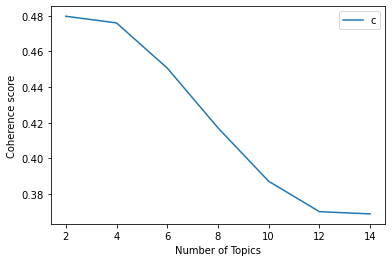

Number of Topics=  2  has Coherence Value of 0.4798
Number of Topics=  4  has Coherence Value of 0.476
Number of Topics=  6  has Coherence Value of 0.4506
Number of Topics=  8  has Coherence Value of 0.4171
Number of Topics=  10  has Coherence Value of 0.3871
Number of Topics=  12  has Coherence Value of 0.3701
Number of Topics=  14  has Coherence Value of 0.3688


In [23]:
# Plot a graph
x = range(start, limit, step)

plt.plot(x, coherence_values)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

# Display Coherence scores with 4 decimals
for m, cv in zip(x, coherence_values):
    print('Number of Topics= ', m, " has Coherence Value of", round(cv, 4))

## <font color=green>P3.2 - Build **LDA model**<font>

In [24]:
# Import libraries
import matplotlib.pyplot as plt
import gensim
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# Build the LDA model ~10 min run
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=4,
                                            random_state=42,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

# Save model to disk for further use
lda_model.save('lda_model')

# Display Perplexity score
# # Measure how good the model is: lower the better
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Display Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model,
                                     texts=data_words_bigrams,
                                     dictionary=id2word,
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.8135102273006805

Coherence Score:  0.4760072469153719


In [25]:
from pprint import pprint

# Print the keyword of topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.039*"dish" + 0.028*"room" + 0.018*"hotel" + 0.014*"kid" + 0.012*"vegas" + '
  '0.011*"buffet" + 0.009*"chinese" + 0.009*"pasta" + 0.008*"strip" + '
  '0.008*"amount"'),
 (1,
  '0.052*"food" + 0.035*"time" + 0.030*"order" + 0.029*"service" + '
  '0.025*"place" + 0.020*"bad" + 0.019*"minute" + 0.016*"restaurant" + '
  '0.013*"people" + 0.011*"experience"'),
 (2,
  '0.056*"table" + 0.037*"drink" + 0.034*"server" + 0.029*"friend" + '
  '0.026*"bar" + 0.022*"waitress" + 0.020*"burger" + 0.019*"waiter" + '
  '0.015*"dinner" + 0.015*"water"'),
 (3,
  '0.038*"good" + 0.020*"place" + 0.017*"pizza" + 0.017*"food" + '
  '0.016*"chicken" + 0.011*"price" + 0.010*"sauce" + 0.010*"well" + '
  '0.009*"side" + 0.008*"meat"')]


## <font color=green>P3.3 - Visualize the model result</font>

### <font color=blue>P3.3.2 - t-SNE 3D visualization</font>

We can visualize the topics Clusters of documents in a **3D space** using **T-SNE** (*t-distributed stochastic neighor embedding*) algorithm.

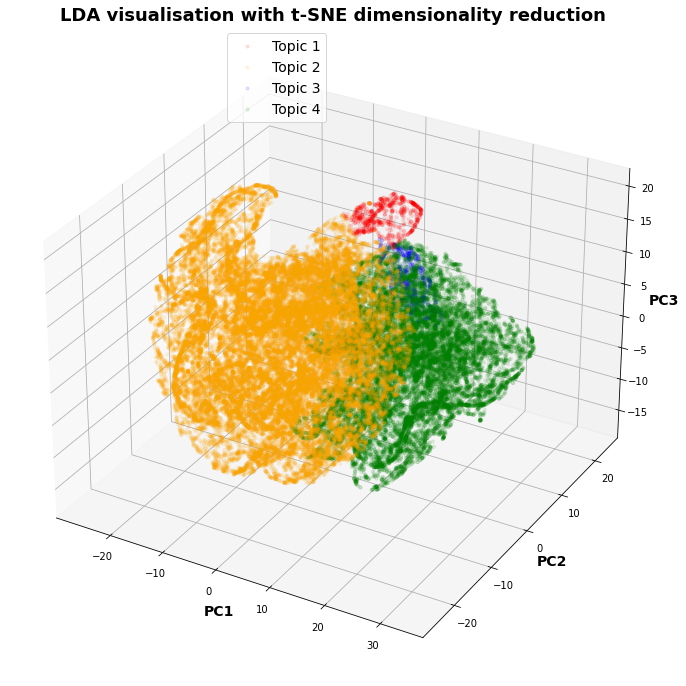

In [1]:
# Import library
from sklearn.manifold import TSNE

# Get TOPIC WEIGHTS and DOMINANT TOPICS ------------
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Create legend for the 3D graph
topic_list = []
for i in np.unique(topic_num):
    topic_list.append('Topic {}'.format(i+1))

# Plot 3D Scatterplot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

x=tsne_lda[:,0]
y=tsne_lda[:,1]
z=tsne_lda[:,2]

color = ['red', 'orange', 'blue', 'green']

for idx, num in enumerate(topic_list):
    ax.scatter3D(x[topic_num==idx],
                 y[topic_num==idx],
                 z[topic_num==idx],
                 color=color[idx],
                 alpha=0.1, label=num)

ax.set_xlabel('PC1', fontsize=14, fontweight='bold')
ax.set_ylabel('PC2', fontsize=14, fontweight='bold')
ax.set_zlabel('PC3', fontsize=14, fontweight='bold')
ax.set_title('LDA visualisation with t-SNE dimensionality reduction',
             fontsize=18, fontweight='bold')
ax.legend(bbox_to_anchor=(0.5, 1), fontsize=14)
plt.show()

### <font color=blue>P3.3.2 - pyLDAvis</font>

**pyLDAvis** is the most commonly used and nice way to visualise the information contained in a topic model.

Below is the implementation for our **LDA model**.

In [27]:
!pip install pyLDAvis

In [28]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

# Save 
pyLDAvis.save_html(vis, 'lda.html')

# Display
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.235737  0.101331       1        1  43.462538
3      0.207059  0.033184       2        1  33.497088
2     -0.110546 -0.340323       3        1  14.828791
0     -0.332250  0.205808       4        1   8.211584, topic_info=            Term          Freq         Total Category  logprob  loglift
257        table  18358.000000  18358.000000  Default  30.0000  30.0000
60          time  33246.000000  33246.000000  Default  29.0000  29.0000
286        order  29018.000000  29018.000000  Default  28.0000  28.0000
56       service  27850.000000  27850.000000  Default  27.0000  27.0000
316        drink  12108.000000  12108.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
506   front_desk    814.597017    815.351259   Topic4  -5.4075   2.4987
1433         rib    834.519629    835.302605   Topic4  -5.3833   2.4987
210        asian    838.140060    838.935994   Topic4  -5.3790   2.4987
827          bbq    814.859753    815.648985   Topic4  -5.4072   2.4987
493        night    832.197310   5566.046902   Topic4  -5.3861   0.5993

[187 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
636       4  0.999527     amount
358       2  0.073232  appetizer
358       3  0.926779  appetizer
210       4  0.998884      asian
211       2  0.999828    average
...     ...       ...        ...
2506      3  0.999274       wine
1056      2  0.999693       wing
474       1  0.999909       work
197       1  0.999928      wrong
198       1  0.999830       year

[185 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

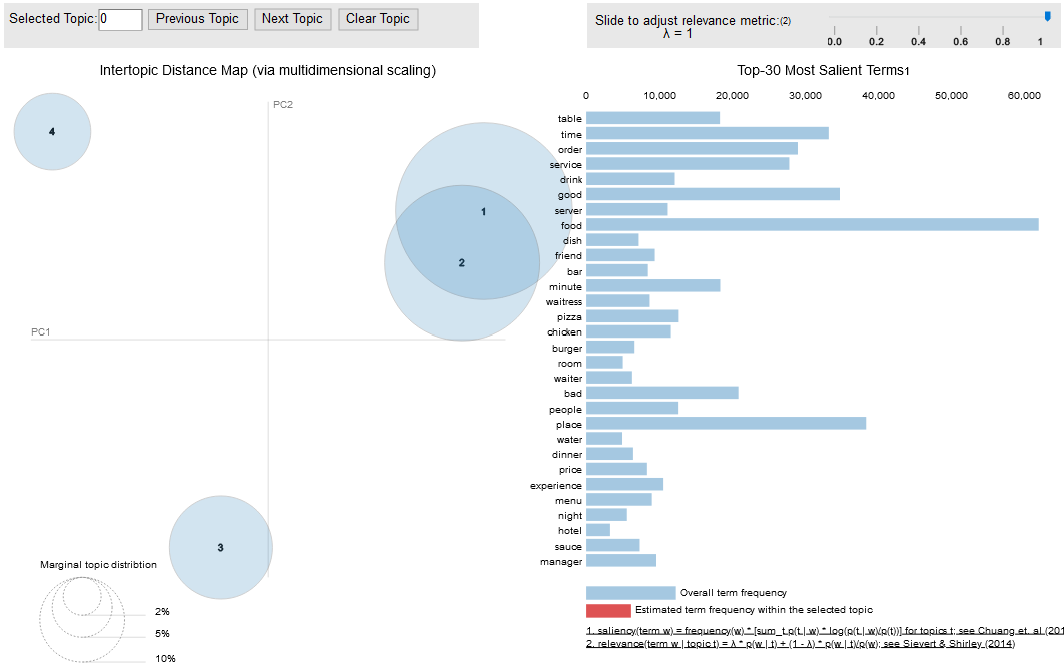

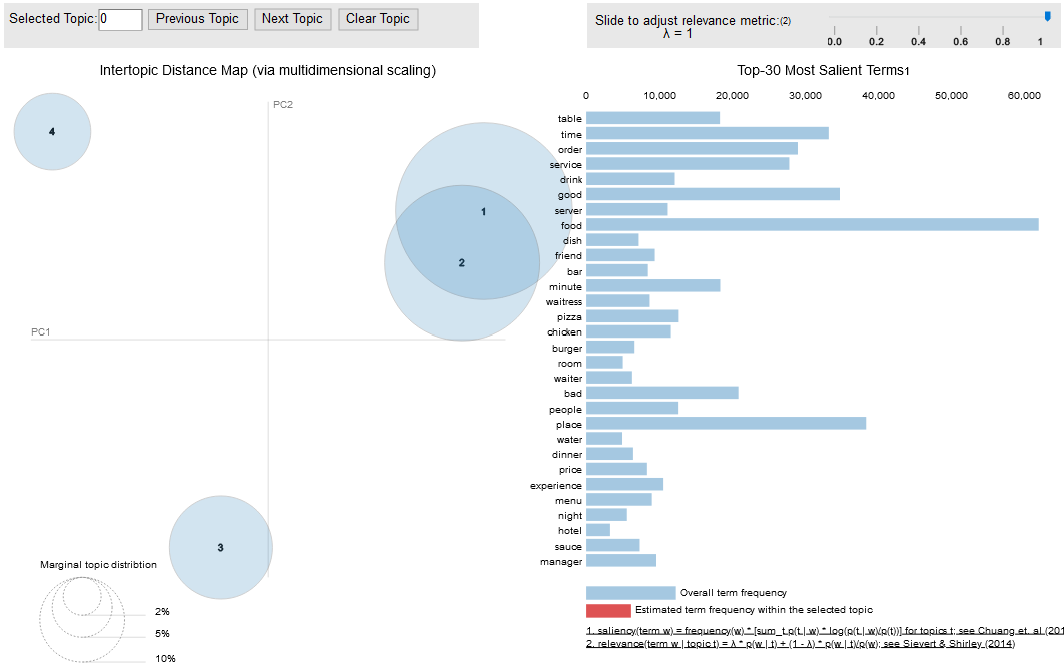

### <font color=blue>P3.3.3 - WordCloud</font>

Though we have already seen what are the **topic keywords** in each topic, a **word cloud** with the size of the words proportional to the weight is another way to visualize the topics.

C:\Users\LaFamille\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\LaFamille\anaconda3\lib\asyncio\events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


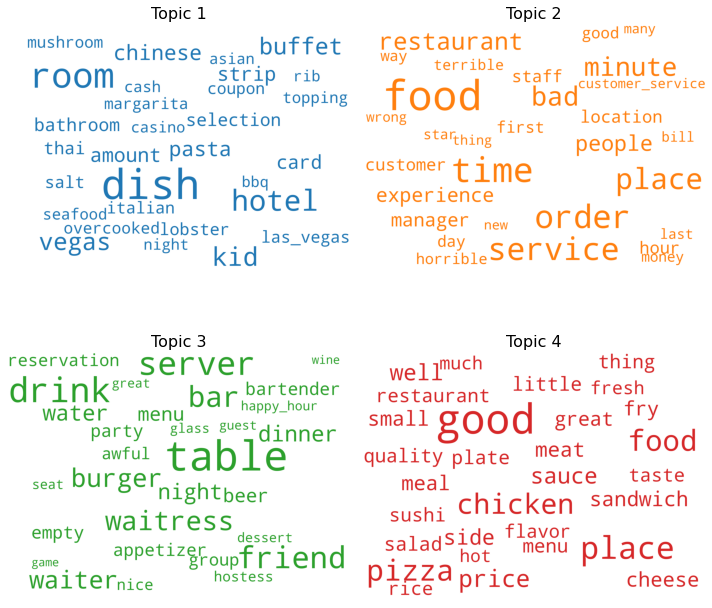

In [29]:
# from gensim.models.ldamodel import LdaModel

# Load LDA model form disk
# lda_model = LdaModel.load('lda_model')

# Wordcloud of Top N words in each topic
from wordcloud import WordCloud, STOPWORDS

# more colors: 'mcolors.XKCD_COLORS'
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(num_words=30, formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

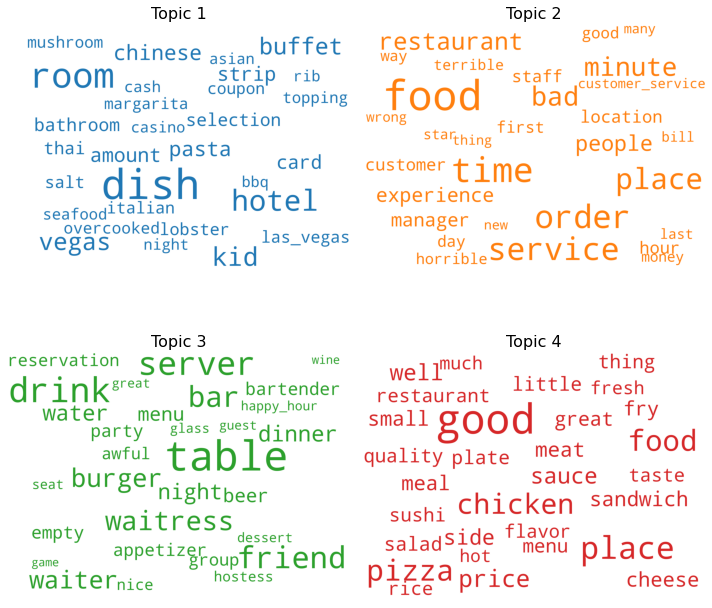

## <font color=green>P3.4 - Infer the topics from keywords</font>

At first sight, our LDA model seems to highlight the following topics, based on pyLDAvis graph:
- 1: insatisfaction about the service, experience, mainly due to time delay;
- 2: poor quality, flavor/taste and variety of food for money;
- 3: management, staff incompetence;
- 4: hygiene, sanitation.

# <font color=salmon>PART 4 - PROCESS AUTOMATION</font>

Once we get new data, we need to be able to reuse all the preprocessing steps we have tested and implemented in PART 2 of our notebook.

Below we have the full code for this purpose, as **automated process** for the following steps:
- Load the text to preprocess;
- Tokenize;
- Remove stopwords;
- Lemmatize;
- Create bigrams;
- Create Bag-of-words (dictionary and corpus).

The <code>**data_text**</code> is ready for **topic modeling**.

## <font color=green>P4.1 - Load all necessary libraries<font>

In [2]:
# Import libraries
import pickle
import spacy
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
from gensim import models
import gensim.corpora as corpora

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LaFamille\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## <font color=green>P4.2 - Create process function (pipeline)<font>

In [3]:
# Read back pickle file
with open ('raw_text.ob', 'rb') as fp:
    data = pickle.load(fp)

# Create stop_words
stop_words = stopwords.words('english')

# Initialize spacy with appropriate language: 'en' model
nlp = spacy.load('en_core_web_sm') #disable=['parser', 'ner']

# Keep only tagger component needed for lemmatization
allowed_postags=['NOUN', 'ADJ']#, 'VERB', 'ADV']

# Define functions for tokenization, stopwords, bigrams and lemmatization
def tokenize(texts):
    for sentence in texts:
        yield(gensim.utils.simple_preprocess(str(sentence),
                                             deacc=True))

# Remove stopwords function
def remove_stopwords(texts):
    return[[w for w in simple_preprocess(str(doc)) if w not in stop_words] for doc in texts]

# Create function for lemmatization
def lemmatization(texts, allowed_postags=allowed_postags):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


# Create function for bigrams
def make_bigrams(texts):
    bigram_model = gensim.models.Phrases(texts,
                                         min_count=1)
    return [bigram_model[doc] for doc in texts]

# Create function for full preprocessing
def text_preprocessing(texts):
    # Call Tokenization function
    x = list(tokenize(texts))
    
    # Call Stopwords removal function
    x = remove_stopwords(x)
    
    # Call Lemmatization function
    x = lemmatization(x, 
                      allowed_postags=allowed_postags)
    
    # Call Bigrams creation function
    data_text = make_bigrams(x)
    
    return data_text

# Call preprocessing function
data_text = text_preprocessing(data)

# Create the dictionary
# Mapping between normalized words and their integer ids
id2word = corpora.Dictionary(data_text)

# Create the corpus : bag-of-words representation of the docs
texts = data_text
corpus = [id2word.doc2bow(text) for text in texts]

# Display readable format of the corpus: (word, frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('bad', 1),
  ('clueless', 1),
  ('country', 1),
  ('critter', 1),
  ('defrosted', 1),
  ('dismal', 1),
  ('entree', 1),
  ('food', 1),
  ('glop', 1),
  ('hill', 1),
  ('jail', 1),
  ('lukewarm', 1),
  ('manager', 1),
  ('patronage', 1),
  ('pickup', 1),
  ('plate', 1),
  ('protection', 1),
  ('real', 1),
  ('texas', 1),
  ('texmex', 1),
  ('waiter', 1),
  ('yard_house', 1)]]

In [4]:
print('Number of unique tokens: {}'.format(len(id2word)))
print('Number of documents: {}'.format(len(corpus)))

Number of unique tokens: 64938
Number of documents: 67879


# <font color=salmon>PART 5 - MISCELLANEOUS</font>

## <font color=green>P5.1 - Find dominant topic in each sentence</font>

The goal here is to find the **topic number** that has the highest percentage contribution in one document.

We can aggregate this information in a table with the function below.

In [30]:
def format_topics_sentences(ldamodel=lda_model,
                            corpus=corpus,
                            texts=data_words_bigrams):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ', '.join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),
                                                                  round(prop_topic,4),
                                                                  topic_keywords]),
                                                       ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

# Call the function
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words_bigrams)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

C:\Users\LaFamille\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.3728,"food, time, order, service, place, bad, minute, restaurant, people, experience","[dismal, lukewarm, defrosted, texmex, glop, waiter, clueless, manager, entree, plate, pickup, patronage, texas, hill, country, jail, critter, bad, protection, yard_house, real, food]"
1,1,1.0,0.4079,"food, time, order, service, place, bad, minute, restaurant, people, experience","[super_bowl, sunday, weak, wonder, hard_rock]"
2,2,1.0,0.5772,"food, time, order, service, place, bad, minute, restaurant, people, experience","[good, several, time, experience, lackluster, food, great, run_mill, good, day, staff, nice, person, blow_mind, alcohol, law, menu, company, day, tip, thing, place, service, excellent, know, probl..."
3,3,1.0,0.3845,"food, time, order, service, place, bad, minute, restaurant, people, experience","[favorite, hotel_casino, day, thing, good, instant, direct, walking, access, main, convention_center, parking, convention, day, parking, hilton, robbery, greed, big_disappointment, star_trek, expe..."
4,4,1.0,0.7280,"food, time, order, service, place, bad, minute, restaurant, people, experience","[horrible, unclean, rancid_foul, odor, poor, service, restaurant, empty, cashier, husband, counter, road, location, unacceptable]"
5,5,3.0,0.5256,"good, place, pizza, food, chicken, price, sauce, well, side, meat","[specific, thing, buffet, horrible, accumulation, average, quality, plenty_option, none, flavorful, hot, worth, other, dessert, section, unthawed, stale, side, asian, section, good, offering, blan..."
6,6,3.0,0.4142,"good, place, pizza, food, chicken, price, sauce, well, side, meat","[margarita, clear_plastic, dickie, cup, drunkin, shrimp, plate, goldfish, feeder, shrimp, platter]"
7,7,1.0,0.3913,"food, time, order, service, place, bad, minute, restaurant, people, experience","[table, floor_dirty, customer, saturday_nite, person, counter, beef, sandwich, bite, trash]"
8,8,3.0,0.3791,"good, place, pizza, food, chicken, price, sauce, well, side, meat","[decent, food, fisherman, congee_queen, nice, decor, much, service, chinese, restaurant, hostess, waitress, place]"
9,9,1.0,0.5146,"food, time, order, service, place, bad, minute, restaurant, people, experience","[fruit, root, good, thing, place, nice, decor, girl, menu, first, time, menu, daughter, banana_smoothie, menu, smoothie, banana, mixed, stuff, able, strawberry_banana, continued, look, menu, diffe..."


## <font color=green>P5.2 - Find the most representative document for each topic</font>

Topic **keyword** may not be enough to make sense of what a topic is about.

To help with understanding the topic, we can find the documents for which a given topic has contributed to the most and infer the topic by reading that document.

In [31]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'],
                                                             ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

C:\Users\LaFamille\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.8856,"dish, room, hotel, kid, vegas, buffet, chinese, pasta, strip, amount","[escapade, dan, laurentide, mon_copain, pendant, action, grace, nous, cherchion, proximite, hotel, nous, dormime, quelque, recherche, internet, nous_avon, choisi, aller, souper, un_dimanche, e_bie..."
1,1.0,0.9129,"food, time, order, service, place, bad, minute, restaurant, people, experience","[take, order, wrong, separate_occasion, first, time, second, time, sure, lady_counter, order, wrong, lady, order, right, item, new, meal, cold, waist, min, correct, order, original, meal, lady_cou..."
2,2.0,0.6873,"table, drink, server, friend, bar, waitress, burger, waiter, dinner, water","[great, music, band, awful, country_music, crap, blue, beer, stand, music, server, great, band, audience, one, couple, rest_audience, music, audience]"
3,3.0,0.8466,"good, place, pizza, food, chicken, price, sauce, well, side, meat","[decent, price, good, dumpling, beef, reddish, brown, tasted, chicken, wing, much, chicken, dry, general_tso, combo, chicken, rice, meal, little, flavor, egg_roll, weird, wonton_soup, bland, sauce..."


## <font color=green>P5.3 - Look at topic distribution across documents</font>

Here, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. 

The below table exposes that information.

In [32]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

C:\Users\LaFamille\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,1.0,"food, time, order, service, place, bad, minute, restaurant, people, experience",630.0,0.0093
1.0,1.0,"food, time, order, service, place, bad, minute, restaurant, people, experience",42477.0,0.6258
2.0,1.0,"food, time, order, service, place, bad, minute, restaurant, people, experience",1232.0,0.0181
3.0,1.0,"food, time, order, service, place, bad, minute, restaurant, people, experience",23540.0,0.3468
4.0,1.0,"food, time, order, service, place, bad, minute, restaurant, people, experience",NaN,NaN
...,...,...,...,...
67874.0,3.0,"good, place, pizza, food, chicken, price, sauce, well, side, meat",NaN,NaN
67875.0,1.0,"food, time, order, service, place, bad, minute, restaurant, people, experience",NaN,NaN
67876.0,3.0,"good, place, pizza, food, chicken, price, sauce, well, side, meat",NaN,NaN
67877.0,1.0,"food, time, order, service, place, bad, minute, restaurant, people, experience",NaN,NaN
